<a href="https://colab.research.google.com/github/kushal-jaat/assignment1/blob/main/housing_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
import pandas as pd

# Mount Google Drive to access the datasets
from google.colab import drive
drive.mount('/content/drive')

# Load the datasets using the provided paths
sales_data = pd.read_csv('/content/drive/My Drive/housing/housing-sales-borough.csv')  # Sales dataset path
rental_data = pd.read_csv('/content/drive/My Drive/housing/housing1.csv')  # Rental dataset path

# Display the first few rows to confirm loading
print("Sales Data Sample:")
print(sales_data.head())

print("\nRental Data Sample:")
print(rental_data.head())



Mounted at /content/drive


<ipython-input-2-3714555cdedc>:8: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv('/content/drive/My Drive/housing/housing-sales-borough.csv')  # Sales dataset path


Sales Data Sample:
   Serial Number  List Year Date Recorded     Town          Address  \
0        2020177       2020    04/14/2021  Ansonia    323 BEAVER ST   
1        2020225       2020    05/26/2021  Ansonia   152 JACKSON ST   
2        2020348       2020    09/13/2021  Ansonia  230 WAKELEE AVE   
3        2020090       2020    12/14/2020  Ansonia      57 PLATT ST   
4         200500       2020    09-07-2021     Avon     245 NEW ROAD   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0          133000     248400.0       0.5354   Residential    Single Family   
1          110500     239900.0       0.4606   Residential     Three Family   
2          150500     325000.0       0.4630    Commercial              NaN   
3          127400     202500.0       0.6291   Residential       Two Family   
4          217640     400000.0       0.5441   Residential    Single Family   

  Non Use Code Assessor Remarks OPM remarks                    Location  
0          

In [3]:
# Inspect the sales_data structure
print("Sales Data Information:")
sales_data.info()

print("\nSales Data Column Summary:")
print(sales_data.describe(include='all'))

print("\nSales Data Sample:")
print(sales_data.head())

# Inspect the rental_data structure
print("\nRental Data Information:")
rental_data.info()

print("\nRental Data Column Summary:")
print(rental_data.describe(include='all'))

print("\nRental Data Sample:")
print(rental_data.head())


Sales Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1048575 non-null  int64  
 1   List Year         1048575 non-null  int64  
 2   Date Recorded     1048573 non-null  object 
 3   Town              1048575 non-null  object 
 4   Address           1048524 non-null  object 
 5   Assessed Value    1048575 non-null  int64  
 6   Sale Amount       1048575 non-null  float64
 7   Sales Ratio       1048575 non-null  float64
 8   Property Type     666129 non-null   object 
 9   Residential Type  655012 non-null   object 
 10  Non Use Code      301508 non-null   object 
 11  Assessor Remarks  160753 non-null   object 
 12  OPM remarks       11422 non-null    object 
 13  Location          249058 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 112.0+ MB

Sales Data Col

In [4]:
# Check for missing values in sales_data
print("Missing Values in Sales Data:")
print(sales_data.isnull().sum())

# Check for missing values in rental_data
print("\nMissing Values in Rental Data:")
print(rental_data.isnull().sum())


Missing Values in Sales Data:
Serial Number             0
List Year                 0
Date Recorded             2
Town                      0
Address                  51
Assessed Value            0
Sale Amount               0
Sales Ratio               0
Property Type        382446
Residential Type     393563
Non Use Code         747067
Assessor Remarks     887822
OPM remarks         1037153
Location             799517
dtype: int64

Missing Values in Rental Data:
id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options        

In [5]:
# Check unique types in each column to identify any mixed data types across the entire dataset
for col in sales_data.columns:
    print(f"\nUnique types in column '{col}':")
    print(sales_data[col].apply(type).value_counts())



Unique types in column 'Serial Number':
Serial Number
<class 'int'>    1048575
Name: count, dtype: int64

Unique types in column 'List Year':
List Year
<class 'int'>    1048575
Name: count, dtype: int64

Unique types in column 'Date Recorded':
Date Recorded
<class 'str'>      1048573
<class 'float'>          2
Name: count, dtype: int64

Unique types in column 'Town':
Town
<class 'str'>    1048575
Name: count, dtype: int64

Unique types in column 'Address':
Address
<class 'str'>      1048524
<class 'float'>         51
Name: count, dtype: int64

Unique types in column 'Assessed Value':
Assessed Value
<class 'int'>    1048575
Name: count, dtype: int64

Unique types in column 'Sale Amount':
Sale Amount
<class 'float'>    1048575
Name: count, dtype: int64

Unique types in column 'Sales Ratio':
Sales Ratio
<class 'float'>    1048575
Name: count, dtype: int64

Unique types in column 'Property Type':
Property Type
<class 'str'>      666129
<class 'float'>    382446
Name: count, dtype: int64



In [6]:
# Replace float values in 'Address' and 'Non Use Code' with "Unknown" to make the data consistent
sales_data['Address'] = sales_data['Address'].fillna("Unknown")
sales_data['Non Use Code'] = sales_data['Non Use Code'].fillna("Unknown").astype(str)

# Verify the changes
print("\nUpdated types in 'Address':")
print(sales_data['Address'].apply(type).value_counts())

print("\nUpdated types in 'Non Use Code':")
print(sales_data['Non Use Code'].apply(type).value_counts())



Updated types in 'Address':
Address
<class 'str'>    1048575
Name: count, dtype: int64

Updated types in 'Non Use Code':
Non Use Code
<class 'str'>    1048575
Name: count, dtype: int64


In [7]:
# Reconfirm filling of 'Address' and 'Non Use Code' if necessary
sales_data['Address'] = sales_data['Address'].fillna("Unknown")
sales_data['Non Use Code'] = sales_data['Non Use Code'].fillna("Unknown").astype(str)


# Drop unnecessary columns such as 'Assessor Remarks', 'OPM remarks', 'Location' (if these are not useful for modeling)
sales_data.drop(columns=['Assessor Remarks', 'OPM remarks', 'Location'], inplace=True)

# Display a summary to verify
print("Updated sales_data info after handling missing values and dropping unnecessary columns:")
print(sales_data.info())


Updated sales_data info after handling missing values and dropping unnecessary columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1048575 non-null  int64  
 1   List Year         1048575 non-null  int64  
 2   Date Recorded     1048573 non-null  object 
 3   Town              1048575 non-null  object 
 4   Address           1048575 non-null  object 
 5   Assessed Value    1048575 non-null  int64  
 6   Sale Amount       1048575 non-null  float64
 7   Sales Ratio       1048575 non-null  float64
 8   Property Type     666129 non-null   object 
 9   Residential Type  655012 non-null   object 
 10  Non Use Code      1048575 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 88.0+ MB
None


In [8]:
# Drop date-related columns as they are not essential for prediction
sales_data.drop(columns=['Date Recorded'], inplace=True)

# Verify the final structure of sales_data
print("Final sales_data info after dropping date-related columns:")
print(sales_data.info())


Final sales_data info after dropping date-related columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1048575 non-null  int64  
 1   List Year         1048575 non-null  int64  
 2   Town              1048575 non-null  object 
 3   Address           1048575 non-null  object 
 4   Assessed Value    1048575 non-null  int64  
 5   Sale Amount       1048575 non-null  float64
 6   Sales Ratio       1048575 non-null  float64
 7   Property Type     666129 non-null   object 
 8   Residential Type  655012 non-null   object 
 9   Non Use Code      1048575 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 80.0+ MB
None


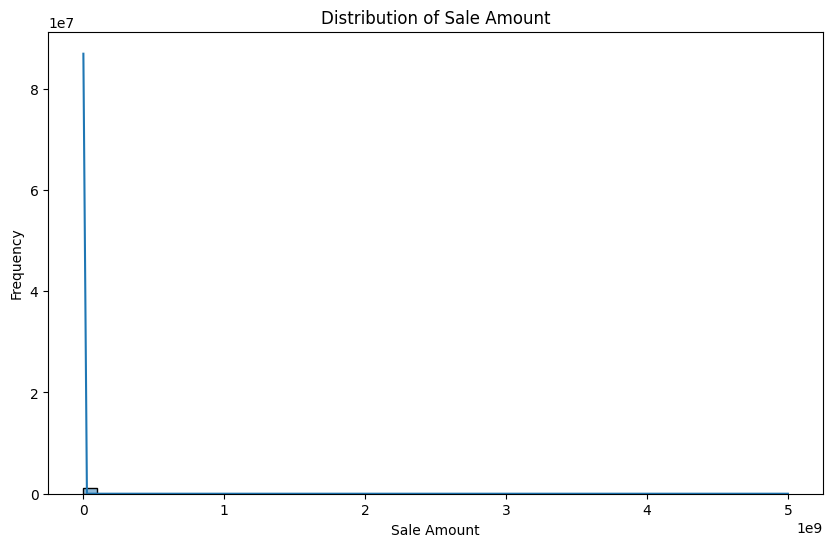

Basic Statistics for 'Sale Amount':
count    1.048575e+06
mean     3.980076e+05
std      5.236187e+06
min      0.000000e+00
25%      1.420000e+05
50%      2.300000e+05
75%      3.700000e+05
max      5.000000e+09
Name: Sale Amount, dtype: float64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of 'Sale Amount'
plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Sale Amount'], bins=50, kde=True)
plt.title('Distribution of Sale Amount')
plt.xlabel('Sale Amount')
plt.ylabel('Frequency')
plt.show()

# Display basic statistics for 'Sale Amount'
print("Basic Statistics for 'Sale Amount':")
print(sales_data['Sale Amount'].describe())


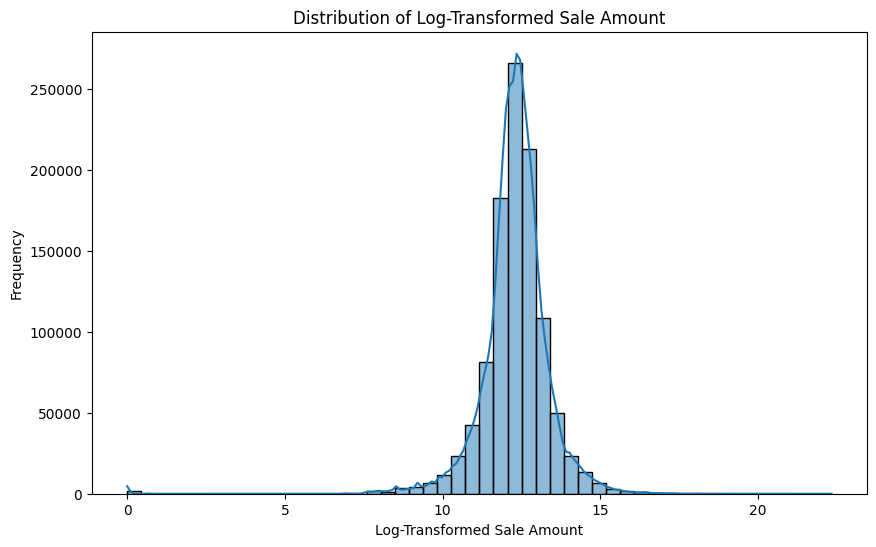

In [10]:
import numpy as np

# Apply log transformation to 'Sale Amount', adding 1 to avoid log(0) for zero values
sales_data['Sale Amount Log'] = np.log1p(sales_data['Sale Amount'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Sale Amount Log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Sale Amount')
plt.xlabel('Log-Transformed Sale Amount')
plt.ylabel('Frequency')
plt.show()


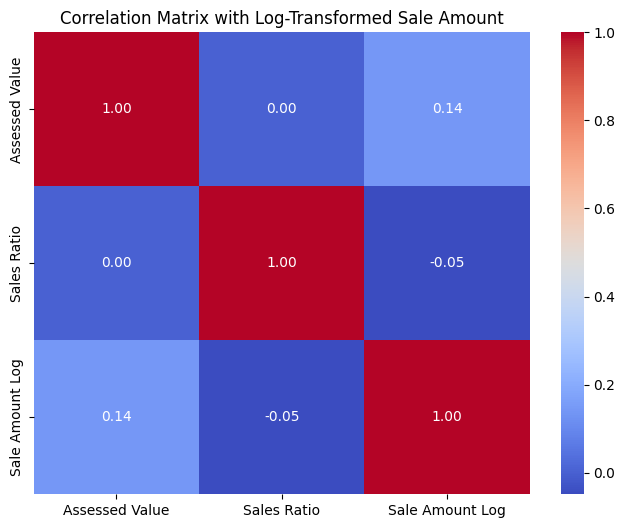

In [11]:
# Add the log-transformed 'Sale Amount Log' column to the correlation matrix
numeric_columns = ['Assessed Value', 'Sales Ratio', 'Sale Amount Log']  # Adjust this list as needed for other numerical features
correlation_matrix = sales_data[numeric_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix with Log-Transformed Sale Amount")
plt.show()


<ipython-input-12-e2aa5c2ca623>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=town_avg_sale_amount.index, y=town_avg_sale_amount.values, palette="viridis")


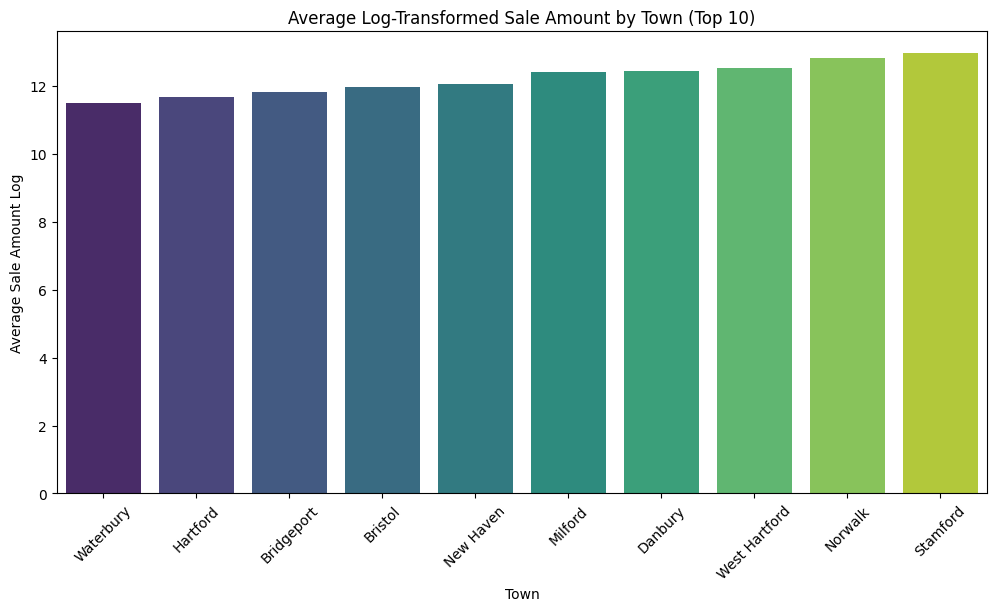

In [12]:
# Calculate the mean Sale Amount Log for each town and sort by frequency
top_towns = sales_data['Town'].value_counts().nlargest(10).index
town_avg_sale_amount = sales_data[sales_data['Town'].isin(top_towns)].groupby('Town')['Sale Amount Log'].mean().sort_values()

# Plotting the average Sale Amount Log by Town
plt.figure(figsize=(12, 6))
sns.barplot(x=town_avg_sale_amount.index, y=town_avg_sale_amount.values, palette="viridis")
plt.title('Average Log-Transformed Sale Amount by Town (Top 10)')
plt.xlabel('Town')
plt.ylabel('Average Sale Amount Log')
plt.xticks(rotation=45)
plt.show()


<ipython-input-13-6060e50aa871>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=property_type_avg_sale_amount.index, y=property_type_avg_sale_amount.values, palette="viridis")


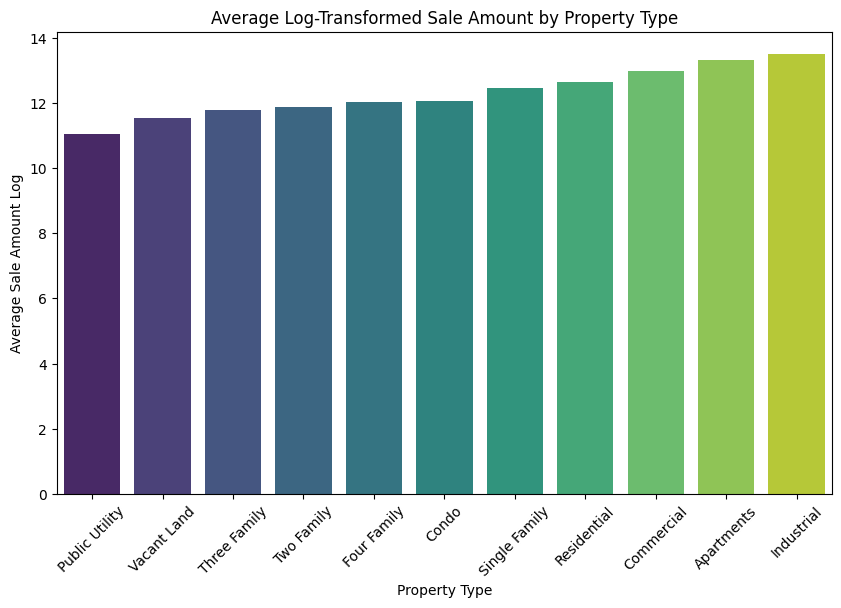

In [13]:
# Calculate the mean Sale Amount Log for each Property Type
property_type_avg_sale_amount = sales_data.groupby('Property Type')['Sale Amount Log'].mean().sort_values()

# Plotting the average Sale Amount Log by Property Type
plt.figure(figsize=(10, 6))
sns.barplot(x=property_type_avg_sale_amount.index, y=property_type_avg_sale_amount.values, palette="viridis")
plt.title('Average Log-Transformed Sale Amount by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Sale Amount Log')
plt.xticks(rotation=45)
plt.show()


<ipython-input-14-62286a986b20>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=residential_type_avg_sale_amount.index, y=residential_type_avg_sale_amount.values, palette="viridis")


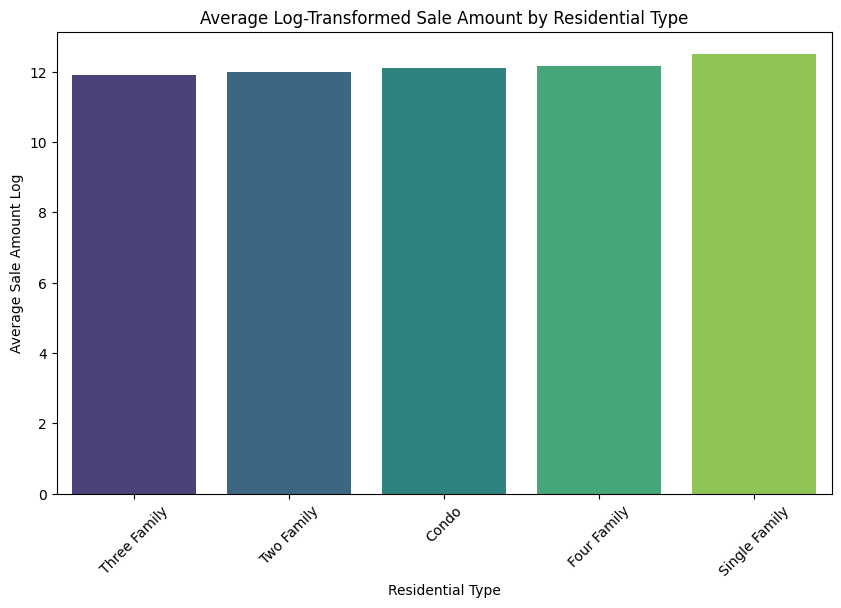

In [14]:
# Calculate the mean Sale Amount Log for each Residential Type
residential_type_avg_sale_amount = sales_data.groupby('Residential Type')['Sale Amount Log'].mean().sort_values()

# Plotting the average Sale Amount Log by Residential Type
plt.figure(figsize=(10, 6))
sns.barplot(x=residential_type_avg_sale_amount.index, y=residential_type_avg_sale_amount.values, palette="viridis")
plt.title('Average Log-Transformed Sale Amount by Residential Type')
plt.xlabel('Residential Type')
plt.ylabel('Average Sale Amount Log')
plt.xticks(rotation=45)
plt.show()


In [15]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Step 1: Target Encoding for 'Town'
# Calculate mean Sale Amount Log for each town
town_target_mean = sales_data.groupby('Town')['Sale Amount Log'].mean()
# Map the mean Sale Amount Log to each town
sales_data['Town_Encoded'] = sales_data['Town'].map(town_target_mean)

# Step 2: One-Hot Encoding for 'Property Type' and 'Residential Type'
# Use pandas get_dummies for one-hot encoding
sales_data = pd.get_dummies(sales_data, columns=['Property Type', 'Residential Type'], drop_first=True)

# Drop the original 'Town' column (if not needed after encoding)
sales_data.drop(columns=['Town'], inplace=True)

# Display the first few rows to confirm the encoding
print(sales_data.head())


   Serial Number  List Year          Address  Assessed Value  Sale Amount  \
0        2020177       2020    323 BEAVER ST          133000     248400.0   
1        2020225       2020   152 JACKSON ST          110500     239900.0   
2        2020348       2020  230 WAKELEE AVE          150500     325000.0   
3        2020090       2020      57 PLATT ST          127400     202500.0   
4         200500       2020     245 NEW ROAD          217640     400000.0   

   Sales Ratio Non Use Code  Sale Amount Log  Town_Encoded  \
0       0.5354      Unknown        12.422800     12.054082   
1       0.4606      Unknown        12.387982     12.054082   
2       0.4630      Unknown        12.691584     12.054082   
3       0.6291      Unknown        12.218500     12.054082   
4       0.5441      Unknown        12.899222     12.767125   

   Property Type_Commercial  ...  Property Type_Public Utility  \
0                     False  ...                         False   
1                     False  ...

In [16]:
# Step 1: Drop irrelevant column 'Address'
if 'Address' in sales_data.columns:
    sales_data = sales_data.drop(columns=['Address'])
    print("Dropped 'Address' column.")

# Step 2: One-hot encode 'Non Use Code'
if 'Non Use Code' in sales_data.columns:
    sales_data = pd.get_dummies(sales_data, columns=['Non Use Code'], drop_first=True)
    print("Applied one-hot encoding to 'Non Use Code'.")

# Step 3: Convert boolean columns to numeric
bool_columns = sales_data.select_dtypes(include=['bool']).columns
if len(bool_columns) > 0:
    sales_data[bool_columns] = sales_data[bool_columns].astype(int)
    print("Converted boolean columns to numeric.")

# Step 4: Verify all columns are numeric
non_numeric_columns = sales_data.select_dtypes(exclude=['number']).columns
if len(non_numeric_columns) == 0:
    print("All columns are numeric. Dataset is ready for modeling!")
else:
    print(f"Non-numeric columns remain: {non_numeric_columns.tolist()}")

# Display the final shape and first few rows of the processed dataset
print(f"Final Sales Dataset Shape: {sales_data.shape}")
print(sales_data.head())


Dropped 'Address' column.
Applied one-hot encoding to 'Non Use Code'.
Converted boolean columns to numeric.
All columns are numeric. Dataset is ready for modeling!
Final Sales Dataset Shape: (1048575, 127)
   Serial Number  List Year  Assessed Value  Sale Amount  Sales Ratio  \
0        2020177       2020          133000     248400.0       0.5354   
1        2020225       2020          110500     239900.0       0.4606   
2        2020348       2020          150500     325000.0       0.4630   
3        2020090       2020          127400     202500.0       0.6291   
4         200500       2020          217640     400000.0       0.5441   

   Sale Amount Log  Town_Encoded  Property Type_Commercial  \
0        12.422800     12.054082                         0   
1        12.387982     12.054082                         0   
2        12.691584     12.054082                         1   
3        12.218500     12.054082                         0   
4        12.899222     12.767125             

In [17]:

from sklearn.preprocessing import StandardScaler

# Select numerical columns to scale
numeric_features = ['Assessed Value', 'Sales Ratio', 'Town_Encoded']
scaler = StandardScaler()

# Apply the scaler to the selected numerical columns
sales_data[numeric_features] = scaler.fit_transform(sales_data[numeric_features])

# Display the first few rows to confirm scaling
print(sales_data[numeric_features].head())


   Assessed Value  Sales Ratio  Town_Encoded
0       -0.088739    -0.005134      -0.45589
1       -0.102275    -0.005175      -0.45589
2       -0.078212    -0.005174      -0.45589
3       -0.092108    -0.005083      -0.45589
4       -0.037823    -0.005130       0.87587


In [18]:
# Step 1: Check for non-numeric columns
non_numeric_columns = sales_data.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in Sales Dataset:")
print(non_numeric_columns)

# Step 2: Display sample values from non-numeric columns
if len(non_numeric_columns) > 0:
    for col in non_numeric_columns:
        print(f"\nSample data from column '{col}':")
        print(sales_data[col].unique()[:5])  # Display a few unique values for inspection
else:
    print("All columns in Sales Dataset are numeric.")


Non-numeric columns in Sales Dataset:
Index([], dtype='object')
All columns in Sales Dataset are numeric.


In [19]:
# # Drop the 'Address' column
# if 'Address' in sales_data.columns:
#     sales_data = sales_data.drop(columns=['Address'])
#     print("Dropped 'Address' column.")


In [21]:
# Define features and target
X = sales_data.drop(columns=['Serial Number', 'Sale Amount', 'Sale Amount Log'])  # Dropping unnecessary columns
y = sales_data['Sale Amount Log']


In [22]:
# import matplotlib.pyplot as plt
# import lightgbm as lgb

# # Get feature importances from the model
# feature_importances = lgb_model.feature_importances_
# feature_names = X_train.columns

# # Create a DataFrame for visualization
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# })

# # Sort features by importance and plot the top 20
# importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# plt.figure(figsize=(10, 8))
# plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
# plt.gca().invert_yaxis()
# plt.title("Top 20 Feature Importances")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.show()


In [23]:
# # Import the necessary libraries
# import lightgbm as lgb
# from sklearn.model_selection import RandomizedSearchCV

# # Updated parameter grid and LightGBM model for faster tuning
# param_grid = {
#     'num_leaves': [20, 31, 40, 50],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 500],
#     'max_depth': [-1, 5, 10],
#     'subsample': [0.8, 1.0]
# }

# # Initialize LightGBM with GPU support (if available) and more parallel jobs
# # Initialize LightGBM without GPU support
# lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)


# # Set up RandomizedSearchCV with increased parallelization and slightly fewer parameter choices
# random_search = RandomizedSearchCV(
#     estimator=lgb_model,
#     param_distributions=param_grid,
#     n_iter=25,  # Increase the number of combinations if desired
#     scoring='neg_mean_squared_error',
#     cv=2,  # Reduce cross-validation folds to 2 for speed
#     verbose=2,
#     random_state=42,
#     n_jobs=-1  # Fully parallelize across available cores
# )

# # Fit RandomizedSearchCV to find the best parameters
# random_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = random_search.best_params_
# best_score = random_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score (negative MSE):", best_score)


In [24]:
# Check missing values in the dataset
print("Missing values in each column:")
print(rental_data.isnull().sum())


Missing values in each column:
id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             79026
parking_options            140687
image_url                       0
description                     2
lat                          1918
long                         1918
state                           0
dtype: int64


In [25]:
# Check data types of each column
print("Data types of each column:")
print(rental_data.dtypes)


Data types of each column:
id                           int64
url                         object
region                      object
region_url                  object
price                        int64
type                        object
sqfeet                       int64
beds                         int64
baths                      float64
cats_allowed                 int64
dogs_allowed                 int64
smoking_allowed              int64
wheelchair_access            int64
electric_vehicle_charge      int64
comes_furnished              int64
laundry_options             object
parking_options             object
image_url                   object
description                 object
lat                        float64
long                       float64
state                       object
dtype: object


In [26]:
# Check column names and shape
print("Columns in the dataset:")
print(rental_data.columns)
print(f"Shape of the dataset: {rental_data.shape}")


Columns in the dataset:
Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state'],
      dtype='object')
Shape of the dataset: (384977, 22)


In [27]:
# Handle missing values for categorical columns (laundry_options, parking_options) without inplace
rental_data['laundry_options'] = rental_data['laundry_options'].fillna(rental_data['laundry_options'].mode()[0])
rental_data['parking_options'] = rental_data['parking_options'].fillna(rental_data['parking_options'].mode()[0])

# Drop rows with missing description, lat, and long
rental_data = rental_data.dropna(subset=['description', 'lat', 'long'])

# Check if there are still missing values
print("Missing values after handling:")
print(rental_data.isnull().sum())

# Show the shape of the dataset after handling missing values
print("Shape after handling missing values:", rental_data.shape)


Missing values after handling:
id                         0
url                        0
region                     0
region_url                 0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
image_url                  0
description                0
lat                        0
long                       0
state                      0
dtype: int64
Shape after handling missing values: (383057, 22)


In [28]:
# Select the columns for one-hot encoding
columns_to_encode = ['region', 'type', 'laundry_options', 'parking_options', 'state']

# Apply one-hot encoding
rental_data_encoded = pd.get_dummies(rental_data, columns=columns_to_encode, drop_first=True)

# Check the columns after encoding
print("Columns after One-Hot Encoding:")
print(rental_data_encoded.columns)

# Check the shape after encoding
print("Shape of dataset after One-Hot Encoding:", rental_data_encoded.shape)


Columns after One-Hot Encoding:
Index(['id', 'url', 'region_url', 'price', 'sqfeet', 'beds', 'baths',
       'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       ...
       'state_sd', 'state_tn', 'state_tx', 'state_ut', 'state_va', 'state_vt',
       'state_wa', 'state_wi', 'state_wv', 'state_wy'],
      dtype='object', length=491)
Shape of dataset after One-Hot Encoding: (383057, 491)


In [29]:
# Dropping unnecessary columns
columns_to_drop = ['id', 'url', 'region_url', 'image_url']
rental_data_encoded.drop(columns=columns_to_drop, inplace=True)

# Check the shape and first few rows after dropping the columns
print(f"Shape of dataset after dropping unnecessary columns: {rental_data_encoded.shape}")
print(rental_data_encoded.head())


Shape of dataset after dropping unnecessary columns: (383057, 487)
   price  sqfeet  beds  baths  cats_allowed  dogs_allowed  smoking_allowed  \
0   1148    1078     3    2.0             1             1                0   
1   1200    1001     2    2.0             0             0                0   
2   1813    1683     2    2.0             1             1                1   
3   1095     708     1    1.0             1             1                1   
4    289     250     0    1.0             1             1                1   

   wheelchair_access  electric_vehicle_charge  comes_furnished  ... state_sd  \
0                  0                        0                0  ...    False   
1                  0                        0                0  ...    False   
2                  0                        0                0  ...    False   
3                  0                        0                0  ...    False   
4                  1                        0                1  

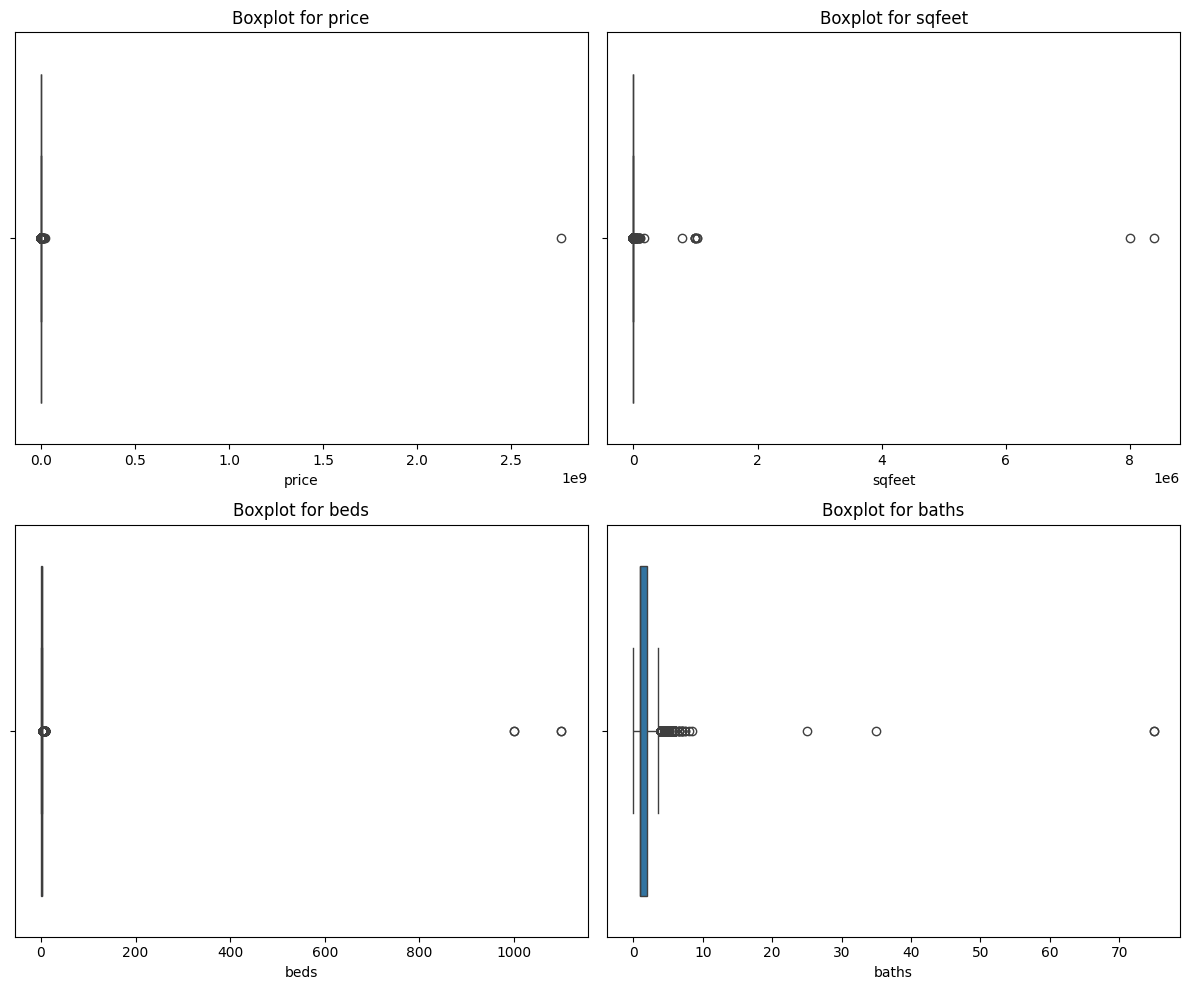

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns to check for outliers
numerical_columns = ['price', 'sqfeet', 'beds', 'baths']

# Plot boxplots to identify outliers
plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=rental_data_encoded[col])
    plt.title(f"Boxplot for {col}")
plt.tight_layout()
plt.show()


In [31]:
import numpy as np

# Reinitialize the cleaned dataset
rental_data_cleaned = rental_data_encoded.copy()

# List of columns to apply log transformation
columns_to_transform = ['price', 'sqfeet', 'beds', 'baths']

# Apply log transformation (adding 1 to avoid log(0))
for column in columns_to_transform:
    rental_data_cleaned[column + '_log'] = np.log1p(rental_data_cleaned[column])

# Check the transformed columns
print("Log-transformed columns preview:")
print(rental_data_cleaned[[col + '_log' for col in columns_to_transform]].head())

# Check the shape of the dataset
print("Shape of the dataset after log transformation:", rental_data_cleaned.shape)


Log-transformed columns preview:
   price_log  sqfeet_log  beds_log  baths_log
0   7.046647    6.983790  1.386294   1.098612
1   7.090910    6.909753  1.098612   1.098612
2   7.503290    7.428927  1.098612   1.098612
3   6.999422    6.563856  0.693147   0.693147
4   5.669881    5.525453  0.000000   0.693147
Shape of the dataset after log transformation: (383057, 491)


In [32]:
# List of log-transformed columns to check for outliers
columns_to_filter = ['price_log', 'sqfeet_log', 'beds_log', 'baths_log']

# Remove outliers based on IQR
for col in columns_to_filter:
    Q1 = rental_data_cleaned[col].quantile(0.25)
    Q3 = rental_data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    rental_data_cleaned = rental_data_cleaned[
        (rental_data_cleaned[col] >= lower_bound) & (rental_data_cleaned[col] <= upper_bound)
    ]

# Check the shape after removing outliers
print("Shape after removing outliers (IQR method):", rental_data_cleaned.shape)


Shape after removing outliers (IQR method): (351307, 491)


In [33]:
# Define explicit bounds for persistent outliers
columns_to_filter = ['price_log', 'sqfeet_log']
for col in columns_to_filter:
    Q1 = rental_data_cleaned[col].quantile(0.25)
    Q3 = rental_data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR  # IQR lower bound
    upper_bound = Q3 + 1.5 * IQR  # IQR upper bound

    # Combine Z-score limits (3 standard deviations) with IQR limits
    mean = rental_data_cleaned[col].mean()
    std = rental_data_cleaned[col].std()
    z_lower_bound = mean - 3 * std
    z_upper_bound = mean + 3 * std

    # Take the stricter of the two methods
    final_lower_bound = max(lower_bound, z_lower_bound)
    final_upper_bound = min(upper_bound, z_upper_bound)

    # Remove rows outside the final bounds
    rental_data_cleaned = rental_data_cleaned[
        (rental_data_cleaned[col] >= final_lower_bound) &
        (rental_data_cleaned[col] <= final_upper_bound)
    ]

# Check the final shape of the dataset
print("Final dataset shape after removing persistent outliers:", rental_data_cleaned.shape)


Final dataset shape after removing persistent outliers: (348403, 491)


In [34]:
# Remove the remaining outliers by setting absolute bounds
for col in ['price_log', 'sqfeet_log']:
    Q1 = rental_data_cleaned[col].quantile(0.25)
    Q3 = rental_data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove all rows outside the IQR bounds
    rental_data_cleaned = rental_data_cleaned[
        (rental_data_cleaned[col] >= lower_bound) &
        (rental_data_cleaned[col] <= upper_bound)
    ]

# Verify the dataset shape
print("Final dataset shape after removing all outliers:", rental_data_cleaned.shape)


Final dataset shape after removing all outliers: (348162, 491)


In [35]:
# Recalculate the number of outliers in the cleaned dataset
outliers_remaining = {}

for col in ['price_log', 'sqfeet_log', 'beds_log', 'baths_log']:
    Q1 = rental_data_cleaned[col].quantile(0.25)
    Q3 = rental_data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count remaining outliers
    outliers_remaining[col] = ((rental_data_cleaned[col] < lower_bound) |
                               (rental_data_cleaned[col] > upper_bound)).sum()

# Display the number of remaining outliers
print("Number of outliers remaining in each column (IQR method):")
print(outliers_remaining)


Number of outliers remaining in each column (IQR method):
{'price_log': 0, 'sqfeet_log': 0, 'beds_log': 0, 'baths_log': 0}


In [36]:
log_columns = ['price_log', 'sqfeet_log', 'beds_log', 'baths_log']


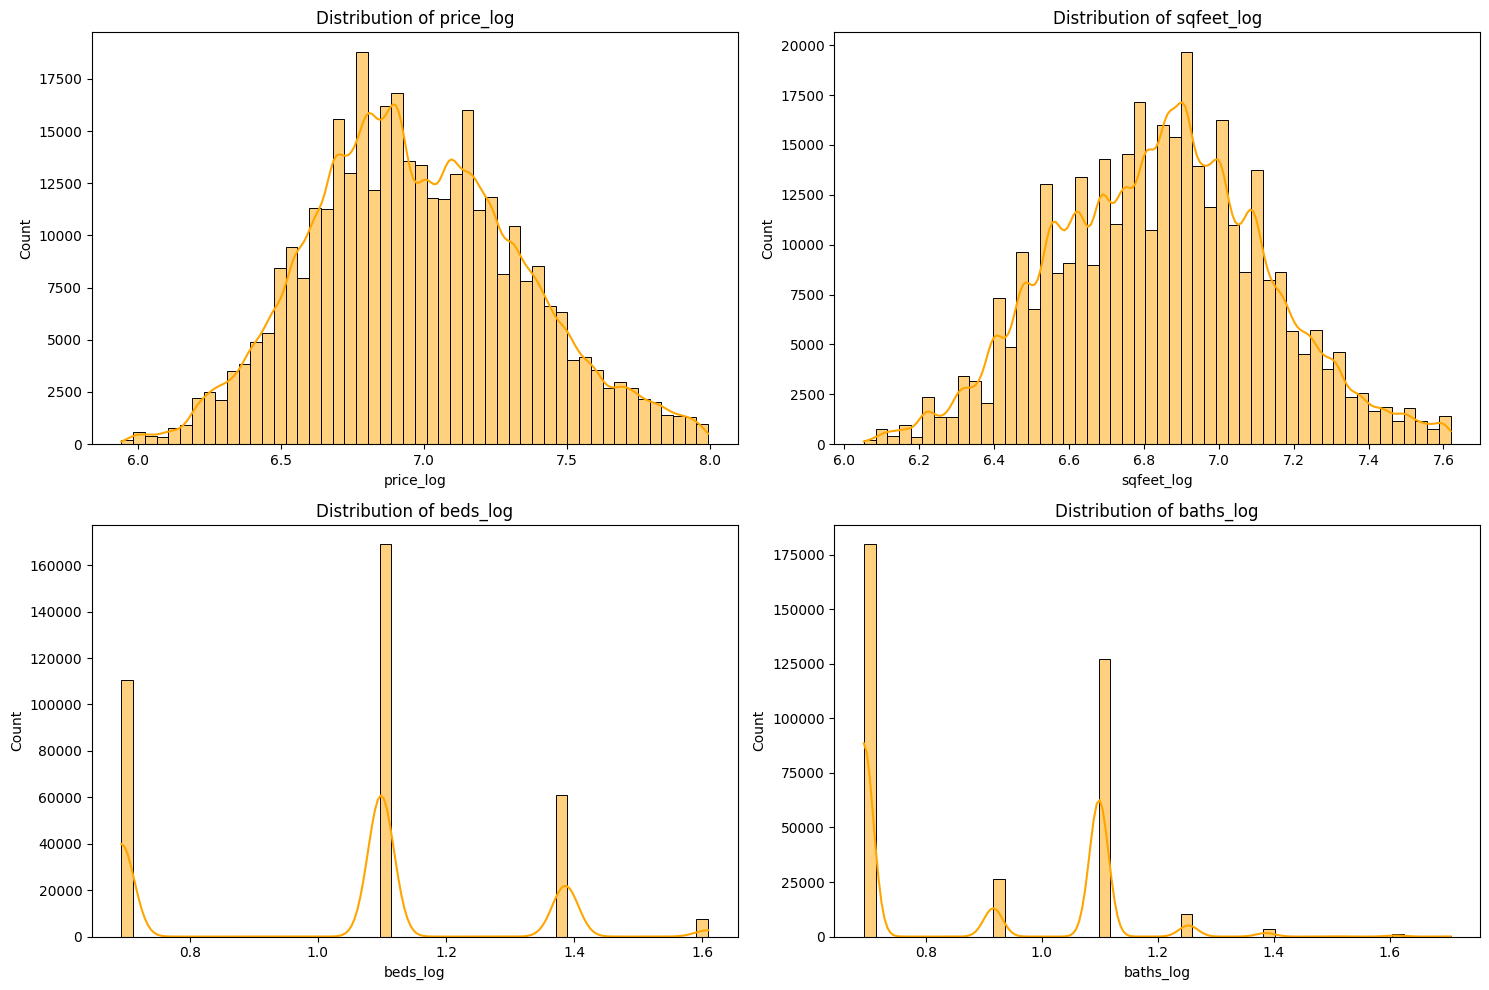

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms to show distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(log_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(rental_data_cleaned[col], kde=True, bins=50, color='orange')
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()



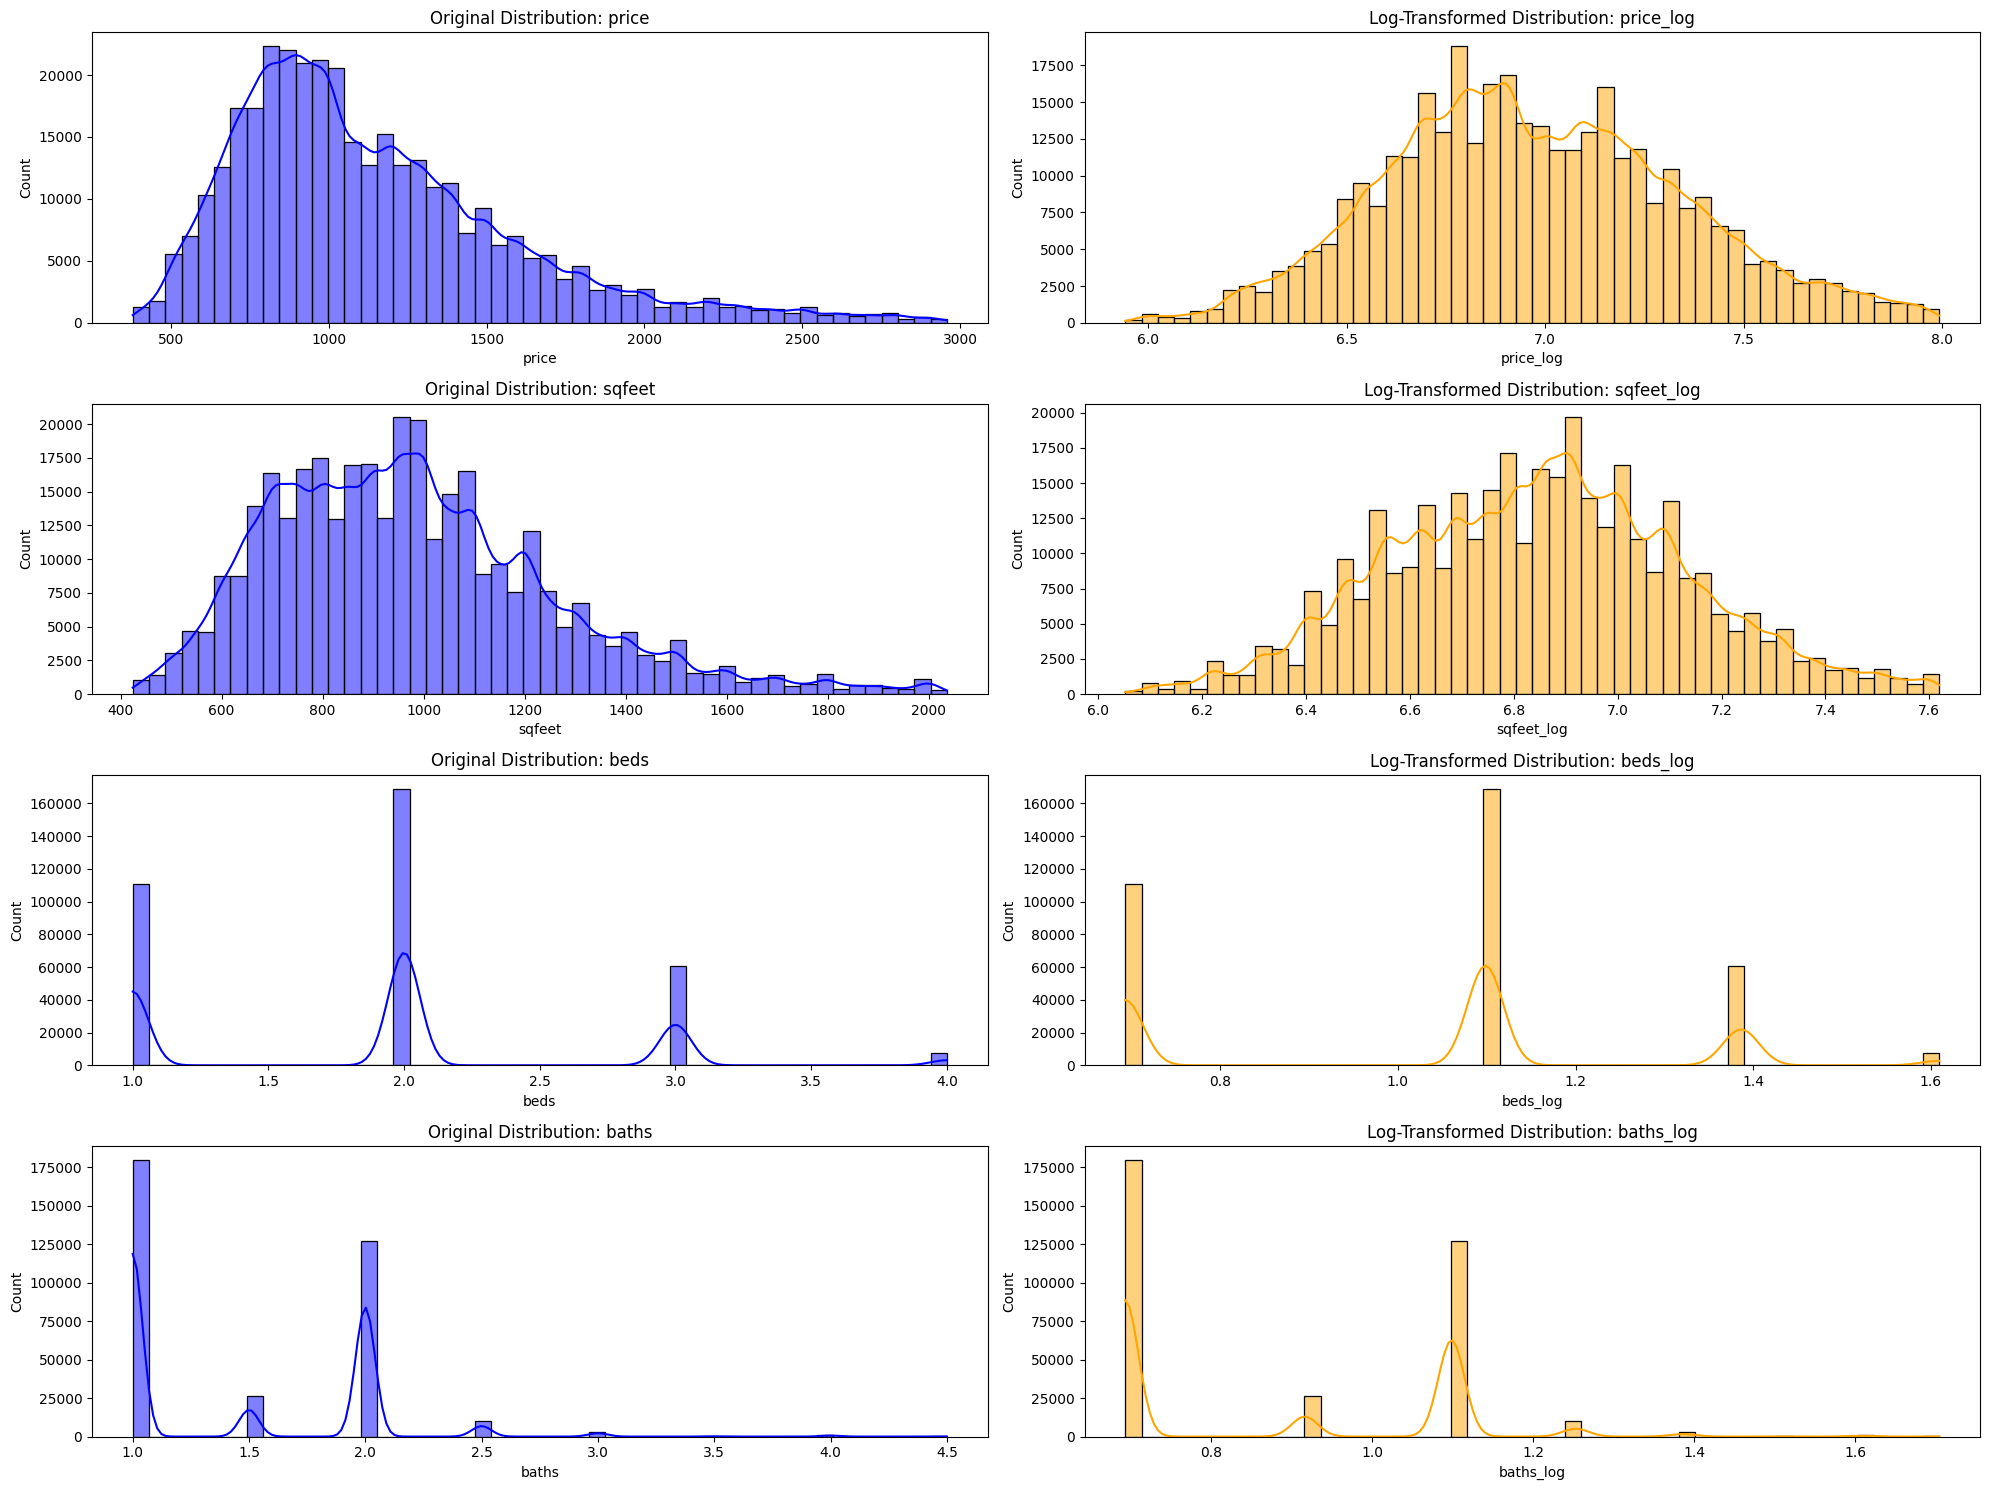

In [38]:
# Compare original and log-transformed distributions
original_columns = ['price', 'sqfeet', 'beds', 'baths']  # Adjust based on your data

plt.figure(figsize=(20, 15))
for i, col in enumerate(original_columns, 1):
    # Original column
    plt.subplot(4, 2, 2 * i - 1)
    sns.histplot(rental_data_cleaned[col], kde=True, bins=50, color='blue')
    plt.title(f'Original Distribution: {col}')

    # Log-transformed column
    plt.subplot(4, 2, 2 * i)
    sns.histplot(rental_data_cleaned[col + '_log'], kde=True, bins=50, color='orange')
    plt.title(f'Log-Transformed Distribution: {col}_log')

plt.tight_layout()
plt.show()


In [39]:
import pandas as pd

# Define original and log-transformed columns
original_columns = ['price', 'sqfeet', 'beds', 'baths']
log_columns = [col + '_log' for col in original_columns]

# Calculate correlations with the target variable (`price_log`)
correlations = {}

for col in original_columns + log_columns:
    correlations[col] = rental_data_cleaned[col].corr(rental_data_cleaned['price_log'])

# Convert correlations to a DataFrame for better readability
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with price_log'])

# Sort correlations by absolute value
correlation_df['Absolute Correlation'] = correlation_df['Correlation with price_log'].abs()
correlation_df = correlation_df.sort_values(by='Absolute Correlation', ascending=False)

# Display the correlation DataFrame
print(correlation_df)


            Correlation with price_log  Absolute Correlation
price_log                     1.000000              1.000000
price                         0.971290              0.971290
sqfeet_log                    0.323045              0.323045
sqfeet                        0.316241              0.316241
baths_log                     0.248052              0.248052
baths                         0.235921              0.235921
beds_log                      0.151342              0.151342
beds                          0.144953              0.144953


In [46]:
# Step 1: Drop the 'description' column
if 'description' in rental_X_train.columns:
    rental_X_train = rental_X_train.drop(columns=['description'])
    rental_X_test = rental_X_test.drop(columns=['description'])
    print("Dropped the 'description' column.")

# Step 2: Verify all remaining columns are numeric or boolean
non_numeric_columns = rental_X_train.select_dtypes(exclude=['number', 'bool']).columns
if len(non_numeric_columns) == 0:
    print("All columns in the rental dataset are numeric or boolean.")
else:
    print(f"Non-numeric columns remain: {non_numeric_columns.tolist()}")

# Step 3: Convert boolean columns to numeric (if not done automatically)
rental_X_train = rental_X_train.astype(float)
rental_X_test = rental_X_test.astype(float)



All columns in the rental dataset are numeric or boolean.


In [40]:
# # Preprocessing to handle non-numeric data
# def preprocess_features(X, dataset_name):
#     # Drop irrelevant columns (e.g., Address, if it exists)
#     if 'Address' in X.columns:
#         print(f"Dropping 'Address' from {dataset_name}")
#         X = X.drop(columns=['Address'])

#     # Identify non-numeric columns
#     non_numeric_columns = X.select_dtypes(include=['object']).columns

#     # Apply encoding for categorical features
#     if len(non_numeric_columns) > 0:
#         print(f"Encoding non-numeric columns for {dataset_name}: {non_numeric_columns.tolist()}")
#         X = pd.get_dummies(X, columns=non_numeric_columns, drop_first=True)

#     return X

# # --------- Sales Dataset ---------
# sales_X = sales_data.drop(columns=['Sale Amount', 'Sale Amount Log'])  # Features only
# sales_y = sales_data['Sale Amount Log']  # Target

# # Preprocess features for the Sales Dataset
# sales_X = preprocess_features(sales_X, "Sales Dataset")

# # Perform train-test split
# sales_X_train, sales_X_test, sales_y_train, sales_y_test = train_test_split(
#     sales_X, sales_y, test_size=0.2, random_state=42
# )

# # --------- Rental Dataset ---------
# rental_X = rental_data_cleaned.drop(columns=['price', 'price_log'])  # Features only
# rental_y = rental_data_cleaned['price_log']  # Target

# # Preprocess features for the Rental Dataset
# rental_X = preprocess_features(rental_X, "Rental Dataset")

# # Perform train-test split
# rental_X_train, rental_X_test, rental_y_train, rental_y_test = train_test_split(
#     rental_X, rental_y, test_size=0.2, random_state=42
# )

# # Verify that the datasets are now numeric
# print(f"Sales Dataset Training Features: {sales_X_train.shape}")
# print(f"Rental Dataset Training Features: {rental_X_train.shape}")


In [41]:
from sklearn.model_selection import train_test_split

# --------- Sales Dataset ---------
# Define features and target
sales_X = sales_data.drop(columns=['Sale Amount', 'Sale Amount Log'])  # Features only
sales_y = sales_data['Sale Amount Log']  # Target

# Perform train-test split for Sales Dataset
sales_X_train, sales_X_test, sales_y_train, sales_y_test = train_test_split(
    sales_X, sales_y, test_size=0.2, random_state=42
)

# --------- Rental Dataset ---------
# Define features and target
rental_X = rental_data_cleaned.drop(columns=['price', 'price_log'])  # Features only
rental_y = rental_data_cleaned['price_log']  # Target

# Perform train-test split for Rental Dataset
rental_X_train, rental_X_test, rental_y_train, rental_y_test = train_test_split(
    rental_X, rental_y, test_size=0.2, random_state=42
)

# Display the shapes of the splits
print("\nData Split Summary:")
print(f"Sales Dataset - Training Features: {sales_X_train.shape}, Testing Features: {sales_X_test.shape}")
print(f"Sales Dataset - Training Target: {sales_y_train.shape}, Testing Target: {sales_y_test.shape}")
print(f"Rental Dataset - Training Features: {rental_X_train.shape}, Testing Features: {rental_X_test.shape}")
print(f"Rental Dataset - Training Target: {rental_y_train.shape}, Testing Target: {rental_y_test.shape}")



Data Split Summary:
Sales Dataset - Training Features: (838860, 125), Testing Features: (209715, 125)
Sales Dataset - Training Target: (838860,), Testing Target: (209715,)
Rental Dataset - Training Features: (278529, 489), Testing Features: (69633, 489)
Rental Dataset - Training Target: (278529,), Testing Target: (69633,)


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Function to train and evaluate a baseline model
def baseline_model(X_train, X_test, y_train, y_test, dataset_name):
    print(f"Evaluating Baseline Model for {dataset_name}...\n")

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print metrics
    print(f"{dataset_name} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 30)

    return model, y_pred

# Baseline model for Sales Dataset
sales_model, sales_y_pred = baseline_model(sales_X_train, sales_X_test, sales_y_train, sales_y_test, "Sales Dataset")

# Baseline model for Rental Dataset
rental_model, rental_y_pred = baseline_model(rental_X_train, rental_X_test, rental_y_train, rental_y_test, "Rental Dataset")


Evaluating Baseline Model for Sales Dataset...

Sales Dataset Metrics:
  MAE: 0.5042
  RMSE: 0.8451
  R² Score: 0.4166
------------------------------
Evaluating Baseline Model for Rental Dataset...

Rental Dataset Metrics:
  MAE: 0.1454
  RMSE: 0.2032
  R² Score: 0.7006
------------------------------


Evaluating Random Forest Model for Sales Dataset...

Sales Dataset Metrics:
  MAE: 0.0088
  RMSE: 0.1593
  R² Score: 0.9793
------------------------------


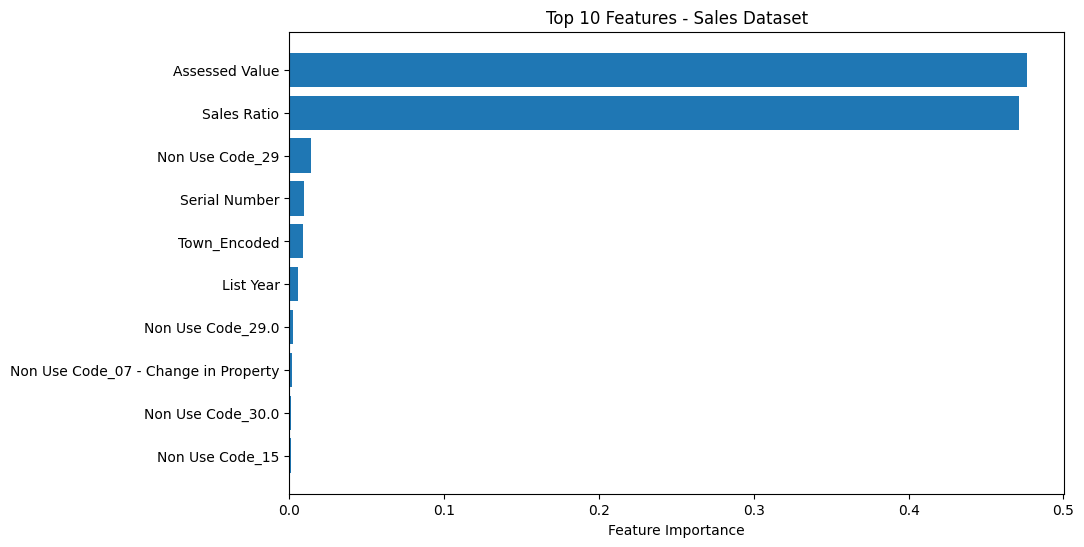

Evaluating Random Forest Model for Rental Dataset...

Rental Dataset Metrics:
  MAE: 0.0524
  RMSE: 0.1108
  R² Score: 0.9110
------------------------------


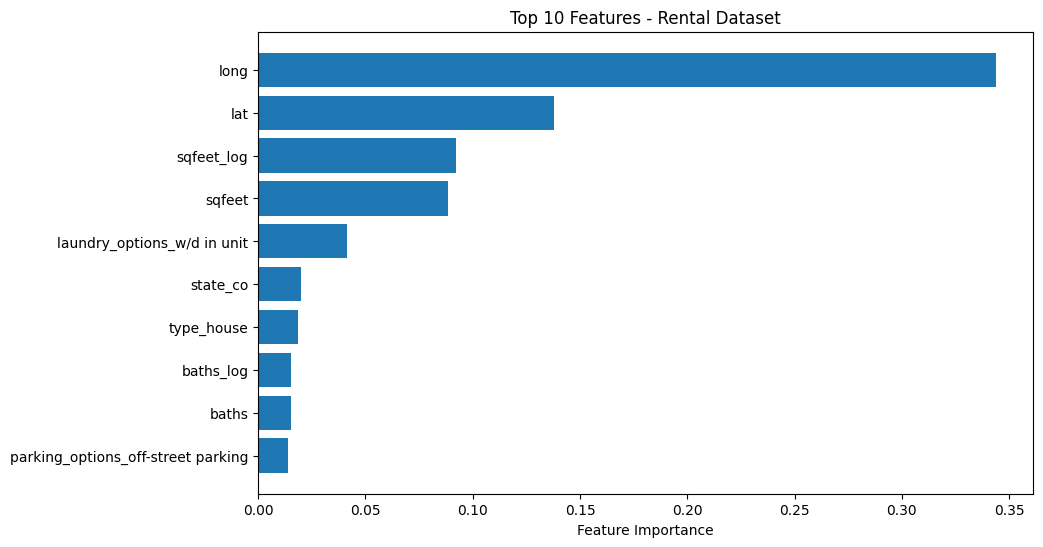

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Function to train, evaluate, and analyze feature importance
def random_forest_model(X_train, X_test, y_train, y_test, dataset_name):
    print(f"Evaluating Random Forest Model for {dataset_name}...\n")

    # Initialize and train the model
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print metrics
    print(f"{dataset_name} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 30)

    # Feature importance analysis
    feature_importances = model.feature_importances_
    feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature {i}" for i in range(X_train.shape[1])]

    # Plot feature importance
    sorted_idx = np.argsort(feature_importances)[::-1][:10]  # Top 10 features
    plt.figure(figsize=(10, 6))
    plt.barh([feature_names[i] for i in sorted_idx][::-1], feature_importances[sorted_idx][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Features - {dataset_name}')
    plt.show()

    return model, y_pred

# Apply the Random Forest model to the Sales Dataset
sales_rf_model, sales_rf_pred = random_forest_model(sales_X_train, sales_X_test, sales_y_train, sales_y_test, "Sales Dataset")

# Apply the Random Forest model to the Rental Dataset
rental_rf_model, rental_rf_pred = random_forest_model(rental_X_train, rental_X_test, rental_y_train, rental_y_test, "Rental Dataset")


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Preprocessing: Scale the data
scaler = StandardScaler()
sales_X_scaled = scaler.fit_transform(sales_X)  # Assuming sales_X and sales_y are defined

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sales_X_scaled, sales_y, test_size=0.2, random_state=42)

# Build the Deep Learning Model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Regression problem
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,  # Start with 50 epochs, you can adjust later
    batch_size=32,
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test).flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Deep Learning Model Metrics:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R² Score: {r2:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
20970/20972 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5636 - mae: 0.9796